In [17]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
import warnings
from matplotlib import pyplot

#suppress convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)
pd.options.mode.chained_assignment = None

The data and variables names are in different files; you will likely need them both. The goal here is to predict the age of the abalone using the other variables in the dataset because the traditional method for aging these organisms is boring and tedious.

There are two challenges (in my opinion):

1. You should try to build the best, stacking-based model(s) to predict age.

2. The UC Irvine Machine Learning Repository classifies this dataset as a "classification" dataset, but age is stored as a numeric (albeit discrete-valued) variable. So, I think it could maybe be reasonable to treat this as a regression problem. It's up to you!

How does your work here compare to your results with bagging?!

In [3]:
# load in the data

column_names = [
    'Sex', 'Length', 'Diameter', 'Height',
    'WholeWeight', 'ShuckedWeight',
    'VisceraWeight', 'ShellWeight', 'Rings'
]
abalone = pd.read_csv("abalone.data", header=None, names=column_names)

# Stacking Models

>knn 0.514 (0.031)
>cart 0.088 (0.111)
>svm 0.515 (0.034)
>stacking 0.560 (0.031)


<positron-console-cell-18>:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


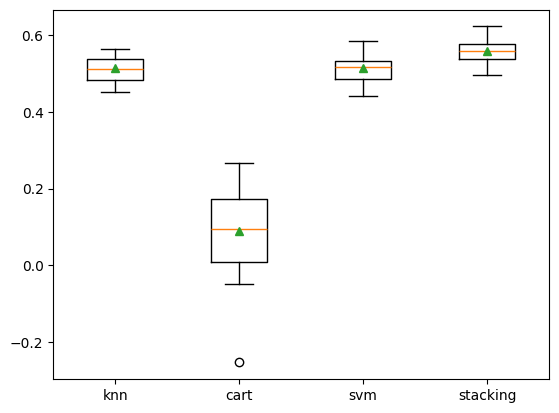

In [18]:

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('knn', KNeighborsRegressor()))
	level0.append(('cart', DecisionTreeRegressor()))
	level0.append(('svm', SVR()))
	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model


# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define x and y
X = pd.get_dummies(abalone.drop("Rings", axis=1), drop_first=True)
y = abalone["Rings"]

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [19]:
model = get_stacking()
model.fit(X, y)
predictions = model.predict(X)
avg_pred = mean(predictions)
avg_pred


np.float64(9.990149134941001)

Looking at the the model results above, the KNN, SVM, and stacking models all demonstrate roughly similar results. However, the SVM model was lower with an r-squared value of 0.088. Overall, the r-squared values were not great around 0.55, indicating that 55% of the variance in rings is explained by the model.

The average age is approximately 9.99, which is similar to the bagging results.